In [370]:
%reload_ext autoreload
%autoreload 2

from agama_spray import *
from utils import *
from models_streams import *

In [371]:
params = [
    1.331894490855406588e+01,
    2.441091252550232582e+01,
    9.783571786742331078e-01,
    8.830960963814488140e-01,
    1.875641070271489019e-01,
    9.683001634771329913e-01,
    8.012867222690761793e+00,
    2.037439625282703393e+00,
    9.089267564398808474e+01,
    3.578894919126337726e+01,
    4.226245547900189337e+01,
    2.926375566231026681e+00,
    4.147323622050326231e-01,
    -3.735887079750737638e-01,
    7.304075075100886494e-01,
    5.421078379317691542e+00
]

# params = [
#     1.273146053477989703e+01,
#     8.150149182871693654e+00,
#     8.173321171888225933e-01,
#     4.116978099996190105e-02,
#     -1.553360237214720607e+00,
#     3.369010603844647955e-02,
#     8.535122153647941801e+00,
#     2.821441644893481371e+00,
#     9.074995066003567956e+01,
#     5.763763249637054997e+01,
#     5.452864009444621018e+01,
#     2.736758445282009067e+00,
#     7.920840615683139019e-01,
#     -1.603054560515305482e+00,
#     -1.414495851287524697e-01,
#     3.734879646494004390e+00
# ]

# params = [
#     1.297304934486500194e+01,
#     2.016255361991831307e+01,
#     1.012929123027472400e+00,
#     -2.337864951967188354e+00,
#     9.733524312100153009e-02,
#     7.135679786312922046e-02,
#     8.762594501908292699e+00,
#     1.030200721233757166e+00,
#     4.578864180542305462e+01,
#     1.224235199541085422e+02,
#     4.972684041571798730e+01,
#     2.892587181791508755e+00,
#     -1.381133314150513047e-01,
#     -6.953875523159055994e-02,
#     3.189788907757262204e-01,
#     4.619190845600189554e+00
# ]
# params = [
#     1.402358441813668577e+01,
#     2.308022091747244531e+01,
#     1.096237775758324151e+00,
#     -1.458244916451303108e-01,
#     -5.699556992087286833e-01,
#     7.606917965339747845e-01,
#     8.949375726924444052e+00,
#     1.167880638527937887e+00,
#     -1.281386604789250896e+02,
#     1.502143169260923514e+02,
#     1.447565595870579784e+02,
#     2.929829992029671981e+00,
#     1.992331609968293199e-02,
#     -1.165976267292455210e-01,
#     -7.004224453790691696e-02,
#     3.154012565205617236e+00
# ]


In [372]:
logM, Rs, q, dirx, diry, dirz, logm, rs, pos_init_x, pos_init_y, pos_init_z, logv, dirvx, dirvy, dirvz, time_total = params

rot_mat = get_mat(dirx, diry, dirz)
rot = R.from_matrix(rot_mat)
euler_angles = rot.as_euler('xyz', degrees=False)

densitynorm = compute_densitynorm(10**logM, Rs, q)
pot_host = agama.Potential(type='Spheroid', densitynorm=densitynorm, scaleradius=Rs, gamma=1, alpha=1, beta=3, 
                            axisRatioY=1, axisRatioZ=q, orientation=euler_angles)

num_particles = int(1e4)  # number of particles in the stream

v_dir = np.array([dirvx, dirvy, dirvz])
v_dir = v_dir/np.linalg.norm(v_dir)
vx = 10**logv * v_dir[0]
vy = 10**logv * v_dir[1]
vz = 10**logv * v_dir[2]

posvel_sat = np.array([pos_init_x, pos_init_y, pos_init_z, vx, vy, vz])

stream, xyz_orbit, time_orbit = create_stream_particle_spray_with_progenitor(time_total, num_particles, pot_host, posvel_sat, 10**logm, rs, gala_modified=True)


_, futur_orbit_sat = agama.orbit(potential=pot_host, ic=posvel_sat, time=1, trajsize=len(time_orbit)+1)
x_futur = futur_orbit_sat[:,0]
y_futur = futur_orbit_sat[:,1]


In [373]:
stream[:, 1][2].shape

(5000, 6)

In [374]:
stream[:, 0][1]

array([-5.421078, -5.419994, -5.41891 , ..., -0.002169, -0.001084,  0.      ], dtype=float32)

In [375]:
time_stream = np.stack(stream[:, 0])
xyz_stream = np.stack(stream[:, 1])[..., :3]

In [376]:
from scipy.interpolate import CubicSpline

x_orbit = xyz_orbit[:, 0]
y_orbit = xyz_orbit[:, 1]
z_orbit = xyz_orbit[:, 2]
r_orbit = np.sqrt(x_orbit**2 + y_orbit**2 + z_orbit**2)

x_stream = xyz_stream[:, -1, 0]
y_stream = xyz_stream[:, -1, 1]
z_stream = xyz_stream[:, -1, 2]
r_stream = np.sqrt(x_stream**2 + y_stream**2) #+ z_stream**2)

x_spline = CubicSpline(time_orbit, x_orbit)
y_spline = CubicSpline(time_orbit, y_orbit)
z_spline = CubicSpline(time_orbit, z_orbit)
r_spline = CubicSpline(time_orbit, r_orbit)

In [377]:
r_prog_at_time = r_spline(time_stream)

all_r_stream = np.linalg.norm(xyz_stream, axis=-1)

arg_take = abs(time_stream) >= abs(time_orbit[-1])
triangular_matrix = np.flipud(np.tri(len(time_orbit), len(time_orbit), k=0, dtype=int))
repeated_triangular_matrix = np.repeat(triangular_matrix, 2, axis=0)
gamma = np.sum((all_r_stream - r_prog_at_time) * repeated_triangular_matrix, axis=-1)
gamma_2 = np.sum((all_r_stream - r_orbit) * repeated_triangular_matrix, axis=-1)

r_orbit
# gamma_min = np.min(gamma)
# gamma_max = np.max(gamma)
# # gamma = 2 * (gamma - gamma_min) / (gamma_max - gamma_min) - 1

array([ 97.445786,  97.996346,  98.54514 , ..., 104.87579 , 105.39792 , 105.91772 ], dtype=float32)

In [378]:
time_stream[-3]

array([-0.002168, -0.002168, -0.002168, ..., -0.000001, -0.      ,  0.      ], dtype=float32)

In [379]:
repeated_triangular_matrix

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [380]:
time_orbit

array([-5.421078, -5.419994, -5.41891 , ..., -0.003253, -0.002168, -0.001084], dtype=float32)

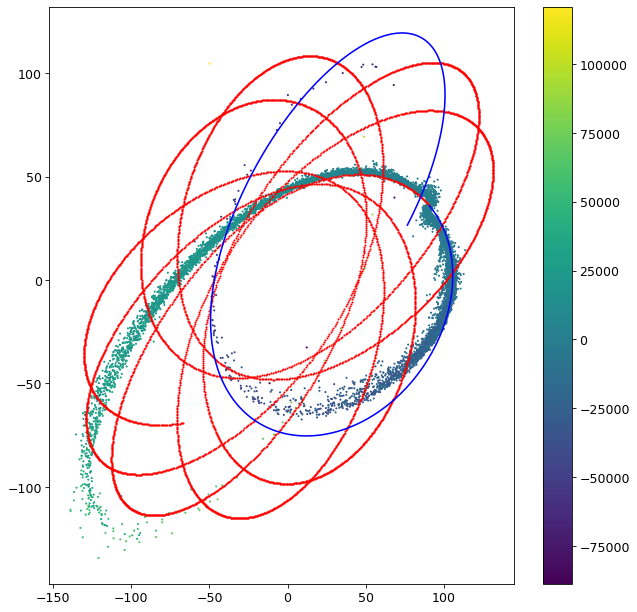

In [381]:
plt.figure(figsize=(10, 10))
plt.scatter(xyz_stream[:, -1, 0], xyz_stream[:, -1, 1], s=1, c=gamma, cmap='viridis')
plt.colorbar()
plt.scatter(xyz_orbit[:, 0], xyz_orbit[:, 1], s=1, c='red')
plt.plot(x_futur, y_futur, c='b')



In [382]:
# Define the number of bins
num_bins = 30
uniform = 'linear'
min_particule = 13

if uniform == 'linear':
    # Compute the bin edges such that each bin has a constant size
    bin_edges = np.linspace(np.min(gamma), np.max(gamma), num_bins + 1)
elif uniform == 'count':
    # Compute the bin edges such that each bin has an equal number of points
    bin_edges = np.percentile(gamma, np.linspace(0, 100, num_bins + 1))

# Bin the gamma values
indices = np.digitize(gamma, bin_edges)

# Compute the average x_stream, y_stream, and r_stream in each bin if there are at least 5 points
average_x_in_bins = [np.median(x_stream[indices == i]) if np.sum(indices == i) >= min_particule else None for i in range(1, num_bins + 1)]
average_y_in_bins = [np.median(y_stream[indices == i]) if np.sum(indices == i) >= min_particule else None for i in range(1, num_bins + 1)]
average_r_in_bins = [np.median(r_stream[indices == i]) if np.sum(indices == i) >= min_particule else None for i in range(1, num_bins + 1)]

In [383]:
arg_keep = np.where( np.array(average_x_in_bins) != None)
average_gamma = bin_edges[:-1][arg_keep]
average_x = np.array(average_x_in_bins)[arg_keep]
average_y = np.array(average_y_in_bins)[arg_keep]

x_spline = CubicSpline(average_gamma, average_x)
y_spline = CubicSpline(average_gamma, average_y)


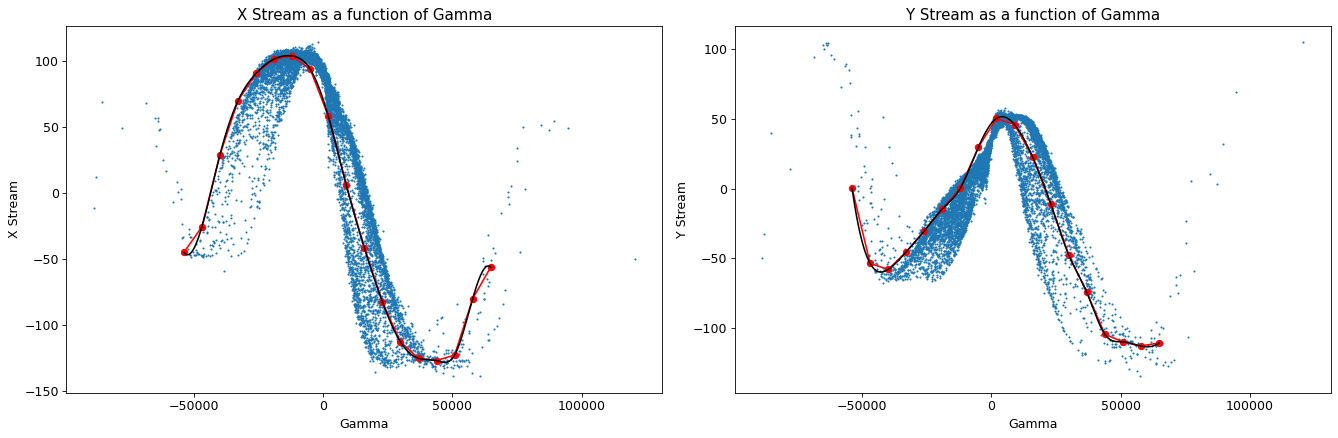

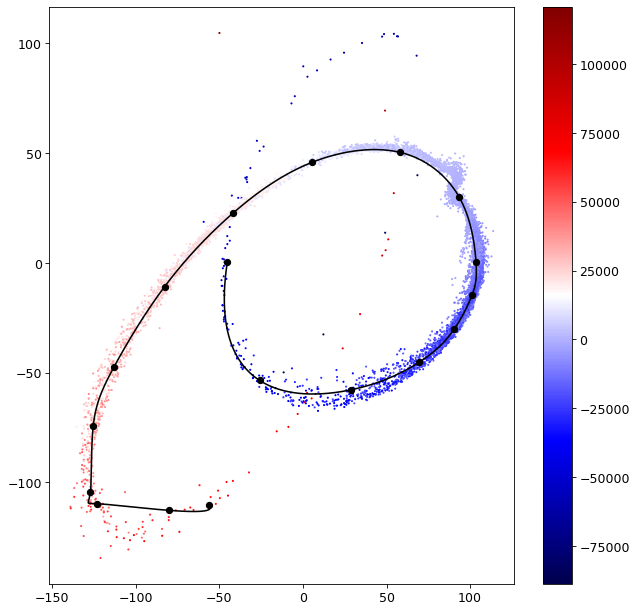

In [384]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.scatter(gamma, x_stream, color='tab:blue', s=1)
plt.plot(bin_edges[:-1], average_x_in_bins, 'ro-')
theo_gamma = np.linspace(average_gamma[0], average_gamma[-1], 1000)
plt.plot(theo_gamma, x_spline(theo_gamma), 'k-')
plt.xlabel('Gamma')
plt.ylabel('X Stream')
plt.title('X Stream as a function of Gamma')

plt.subplot(1, 2, 2)
plt.scatter(gamma, y_stream, color='tab:blue', s=1)
plt.plot(bin_edges[:-1], average_y_in_bins, 'ro-')
theo_gamma = np.linspace(average_gamma[0], average_gamma[-1], 1000)
plt.plot(theo_gamma, y_spline(theo_gamma), 'k-')
plt.xlabel('Gamma')
plt.ylabel('Y Stream')
plt.title('Y Stream as a function of Gamma')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(xyz_stream[:, -1, 0], xyz_stream[:, -1, 1], s=1, c=gamma, cmap='seismic')
plt.colorbar()
# plt.plot(average_x_in_bins, average_y_in_bins, 'ko-')#, s=10)
plt.plot(x_spline(theo_gamma), y_spline(theo_gamma), 'k-')
plt.scatter(average_x, average_y, color='k')
